Name: Patrick Ng  
Email: patng@ischool.berkeley.edu  
Class: W261-2  
Week: 01  
Date of submission: Jan 26, 2016

## HW2.0.  
What is a race condition in the context of parallel computation? Give an example.  
What is MapReduce?  
How does it differ from Hadoop?  
Which programming paradigm is Hadoop based on? Explain and give a simple example in code and show the code running.

**What is a race condition in the context of parallel computation? Give an example. ** 

A race condition happens when multiple execution entities (e.g. threads, processes, etc)
are accessing or modifying a common resource at the same time, and the order of access can impact the result.  

For example, consider the following logic, where A is a global variable:  
```
temp = A
temp = temp + 1
A = temp
```
It will increase the value of A by one.  If it is run twice sequentially, A will be increased by two.  However, if two threads are running it at the same time, there is a chance that A will only be increased by one instead of two.  
<br/>

**What is MapReduce?  **

MapReduce can refer to three distinct but related concepts.  

First, MapReduce codifies a generic recipe for processing large datasets that consists of two stages.
- In the first stage, a user-specified computation is applied over all input records in a dataset.
- These operations occur in parallel and yield intermediate output that is then aggregated by another user-specified computation.

Second, MapReduce can refer to the execution framework (i.e., the “runtime”) that coordinates the execution of programs written in this particular style.  

Finally, MapReduce can refer to the software implementation of the programming model and the execution framework.

<br/>
**How does it differ from Hadoop?**  

Hadoop is the software implementation of the MapReduce programming model and the execution framework.  In Hadoop v2.0, the main components include MapReduce (the programming model), YARN (the resource manager) and HDFS (the distributed file system).

<br/>
**Which programming paradigm is Hadoop based on? Explain and give a simple example in code and show the code running.**

Hadoop is based on the MapReduce programming model.  You can find examples of its code and its running in HW2.1-HW2.5.

## HW2.1. Sort in Hadoop MapReduce
Given as input: Records of the form < integer, “NA” >, where integer is any integer, and “NA” is just the empty string.
Output: sorted key value pairs of the form < integer, “NA” > in decreasing order; what happens if you have multiple reducers? Do you need additional steps? Explain.

Write code to generate N  random records of the form < integer, “NA” >. Let N = 10,000.
Write the python Hadoop streaming map-reduce job to perform this sort. Display the top 10 biggest numbers. Display the 10 smallest numbers

### Generate random numbers

In [73]:
%%writefile genrand.py
#!/usr/bin/python
import random
import sys

nums = 10000
if len(sys.argv) > 1:
    nums = int(sys.argv[1])

random.seed(0)
for i in range(nums):
    print '< %d, "NA" >' % random.randint(-1000000, 1000000)

Overwriting genrand.py


In [15]:
!chmod +x genrand.py

### Mapper

In [71]:
%%writefile mapper.py
#!/usr/bin/python
import sys
import re

# The regex which captures the integer from a line in the format < integer, "NA" >
regex = re.compile(r'\<\s*(-?\d+)\s*,\s*\"NA\"\s*\>')

# input comes from STDIN (standard input)
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    
    # Get the integer from the line
    result = regex.findall(line)
    if len(result) == 0:
        # Cannot find any integer. Could be a corrupted input line.  Skip it.
        continue
    
    # print the integer as the key of the output.  Absence of value means there is no value.
    print result[0]

Overwriting mapper.py


### Reducer

In [20]:
%%writefile reducer.py
#!/usr/bin/python
import sys

# input comes from STDIN
for line in sys.stdin:
    print '<%s, "NA">' % line.strip()

Overwriting reducer.py


### Quick test

In [80]:
!python genrand.py 20 | python mapper.py | sort -g -r | python reducer.py

<965571, "NA">
<819493, "NA">
<816226, "NA">
<804332, "NA">
<688844, "NA">
<620435, "NA">
<567597, "NA">
<515909, "NA">
<511609, "NA">
<236738, "NA">
<166764, "NA">
<22549, "NA">
<9374, "NA">
<-46806, "NA">
<-158857, "NA">
<-190132, "NA">
<-393375, "NA">
<-436325, "NA">
<-482167, "NA">
<-498988, "NA">


## Run it in hadoop

### start yarn and hdfs

In [32]:
!/usr/local/Cellar/hadoop/2.7.1/sbin/start-yarn.sh
!/usr/local/Cellar/hadoop/2.7.1/sbin/start-dfs.sh

starting yarn daemons
starting resourcemanager, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/yarn-patrickng-resourcemanager-Patricks-MacBook-Pro.local.out
localhost: starting nodemanager, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/yarn-patrickng-nodemanager-Patricks-MacBook-Pro.local.out
16/01/23 12:32:56 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Starting namenodes on [localhost]
localhost: starting namenode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-patrickng-namenode-Patricks-MacBook-Pro.local.out
localhost: starting datanode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-patrickng-datanode-Patricks-MacBook-Pro.local.out
Starting secondary namenodes [0.0.0.0]
0.0.0.0: starting secondarynamenode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-patrickng-secondarynamenode-Patricks-MacBook-Pro.local.out
16/01/23 12:33:12 WARN uti

In [75]:
!echo "Generating random numbers, each in the range [-1000000, 1000000]."
!rm -f randomNums.txt
!./genrand.py 10000 >> randomNums.txt

Generating random numbers, each in the range [-1000000, 1000000].


In [76]:
# upload input file to hdfs
!hdfs dfs -rm -f randomNums.txt
!hdfs dfs -put randomNums.txt

16/01/23 13:20:59 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted randomNums.txt
16/01/23 13:21:01 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [77]:
# Hadoop streaming command
!hdfs dfs -rm -r sortRandomNums
!hadoop jar $HADOOP_INSTALL/share/hadoop/tools/lib/hadoop-*streaming*.jar -D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator -D mapred.text.key.comparator.options="-nr" -mapper mapper.py -reducer reducer.py -input randomNums.txt -output sortRandomNums

16/01/23 13:21:04 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted sortRandomNums
16/01/23 13:21:07 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [78]:
# Show the reults
!rm -f w2.1.result
!hdfs dfs -get sortRandomNums/part-00000 w2.1.result
!echo
!echo "10 biggest numbers:"
!head -n 10 w2.1.result
!echo
!echo "10 smallest numbers:"
!tail -n 10 w2.1.result

16/01/23 13:21:16 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/23 13:21:17 WARN hdfs.DFSClient: DFSInputStream has been closed already

10 biggest numbers:
<999806, "NA">	
<999764, "NA">	
<999727, "NA">	
<999663, "NA">	
<999371, "NA">	
<998888, "NA">	
<998841, "NA">	
<998388, "NA">	
<997707, "NA">	
<997613, "NA">	

10 smallest numbers:
<-997715, "NA">	
<-997902, "NA">	
<-997975, "NA">	
<-998040, "NA">	
<-998770, "NA">	
<-998808, "NA">	
<-999519, "NA">	
<-999672, "NA">	
<-999732, "NA">	
<-999954, "NA">	


### What happens if you have multiple reducers? Do you need additional steps?

If I have multiple reducers, then I have multiple sorted results.  I need to merge these sorted lists into a single sorted list, either by writing my own code, or by passing these results to a single reducer.

## HW2.2 WORDCOUNT

Using the Enron data from HW1 and Hadoop MapReduce streaming, write the mapper/reducer job that  will determine the word count (number of occurrences) of each white-space delimitted token (assume spaces, fullstops, comma as delimiters). Examine the word “assistance” and report its word count results.

 
CROSSCHECK: 
> grep assistance enronemail_1h.txt|cut -d$'\t' -f4| grep assistance|wc -l    
> 8    

#NOTE  "assistance" occurs on 8 lines but how many times does the token occur? 10 times! This is the number we are looking for!

### Mapper

In [85]:
%%writefile mapper.py
#!/usr/bin/python
import sys
import re

# Regex for splitting the words.  Delimiters are: <spaces> , .
regex = re.compile(r"[\s,\.]+")

# input comes from STDIN (standard input)
for line in sys.stdin:
    parts = re.split("\t", line)

    # Extract the text parts
    subject = "" if parts[2].strip() == "NA" else parts[2]
    body = "" if parts[3].strip() == "NA" else parts[3]
    text = subject + " " + body
    
    words = filter(None, regex.split(text))
    for word in words:
        print "%s\t1" % word

Overwriting mapper.py


### Reducer

In [83]:
%%writefile reducer.py
#!/usr/bin/python
import sys

totalCount = 0
prev = None # the word previously seen

# input comes from STDIN
for line in sys.stdin:
    parts = line.split('\t')
    word = parts[0]
    count = int(parts[1])
    
    # If we have encountered a new word, output the answer of the previous word
    if prev != word:
        if prev is not None:
            print "%s\t%d" % (prev, totalCount)
            totalCount = 0
            
    totalCount += 1
    prev = word

# Output for the last word seen
if prev is not None:
    print "%s\t%d" % (prev, totalCount)
        

Overwriting reducer.py


### Quick test

In [86]:
!head -n 3 enronemail_1h.txt | python mapper.py | sort | python reducer.py

"	1
""	4
&	1
----------------------forwarded	1
01/17/2000	2
03:22	1
06:44	1
1	1
1-5	3
10	1
3-7394	1
33597	1
560	1
6	1
8	1
8-10	1
8-12	3
9	1
@	21
a	8
all	2
allen/hou/ect	1
also	1
am	3
an	2
and	11
any	9
appropriate	1
are	8
armstrong/corp/enron	2
as	3
ask	1
asking	1
at	2
attached	1
attend	2
attendance	1
attending	1
audience	2
available	2
back	2
be	6
being	1
below	3
benefit	1
brad	1
buck/hou/ect	1
by	2
call	1
carrera/hou/ect	1
cc:	1
challenges	1
charge	1
chosen	1
christine	1
christmas	1
cindy	1
classrom	1
client	1
clients	1
coaching	1
communicating	2
completing	1
conduct	1
conn/corp/enron	1
contact	1
cost	1
courses	1
cross-section	1
currently	1
curriculum	4
curriculum!	1
date	1
david	1
delegating	1
depending	1
description	1
design	1
designed	1
development	3
directing	1
discussion	1
ect	17
effectively	2
employee	2
ena	2
energy	1
enron	3
enron_development	1
eops	1
evaluate	2
even	1
exception	1
excited	1
experience	1
facilitators	1
farm	1
feb	3
february	3
find	1
fine-tuning	1
focus	1
followin

### Run it in hadoop

In [87]:
# Upload input file to HDFS
!hdfs dfs -rm -f enronemail_1h.txt
!hdfs dfs -put enronemail_1h.txt

16/01/23 15:03:54 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/23 15:03:56 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [88]:
# Run the hadoop streaming command
!hdfs dfs -rm -r wordCount
!hadoop jar $HADOOP_INSTALL/share/hadoop/tools/lib/hadoop-*streaming*.jar -mapper mapper.py -reducer reducer.py -input enronemail_1h.txt -output wordCount

16/01/23 15:04:02 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `wordCount': No such file or directory
16/01/23 15:04:04 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [91]:
# Show the results
!rm -f w2.2.result
!hdfs dfs -get wordCount/part-00000 w2.2.result
!echo
!echo "Occurrence count of 'assistance':"
!grep 'assistance' w2.2.result


16/01/23 15:13:36 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/23 15:13:36 WARN hdfs.DFSClient: DFSInputStream has been closed already

Occurrence count of 'assistance':
assistance	10


## HW2.2.1  
Using Hadoop MapReduce and your wordcount job (from HW2.2) determine the top-10 occurring tokens (most frequent tokens)

## Mapper

In [97]:
%%writefile mapper.py
#!/usr/bin/python
import sys

# input comes from STDIN (standard input)
for line in sys.stdin:
    line = line.strip()
    parts = line.split('\t')
    
    # Output is: count, and then word
    print "%s\t%s" % (parts[1], parts[0])

Overwriting mapper.py


## Reducer

In [103]:
%%writefile reducer.py
#!/usr/bin/python
import sys

count = 0

# input comes from STDIN
for line in sys.stdin:
    line = line.strip()
    print line
    
    # Display only the top 10 words
    count += 1
    if count == 10:
        break;

Overwriting reducer.py


### Quick test

In [104]:
!cat w2.2.result | python mapper.py | sort -g -r | python reducer.py

1240	the
914	to
659	and
556	of
527	a
415	in
407	you
389	your
369	for
361	@


### Run it in hadoop

In [105]:
# Hadoop streaming command
# Please note that we use the output from HW2.2 as input.
!hdfs dfs -rm -r top10
!hadoop jar $HADOOP_INSTALL/share/hadoop/tools/lib/hadoop-*streaming*.jar -D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator -D mapred.text.key.comparator.options="-nr" -mapper mapper.py -reducer reducer.py -input wordCount -output top10

16/01/23 15:32:42 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted top10
16/01/23 15:32:45 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [106]:
# Show the results
!echo 'Top 10 occurring words:'
!hdfs dfs -cat top10/part-00000 | cut -d$'\t' -f 2


Top 10 occurring words:
16/01/23 15:32:53 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
the
to
and
of
a
in
you
your
for
@


## HW2.3. Multinomial NAIVE BAYES with NO Smoothing
Using the Enron data from HW1 and Hadoop MapReduce, write  a mapper/reducer job(s) that
   will both learn  Naive Bayes classifier and classify the Enron email messages using the learnt Naive Bayes classifier. Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). Note: for multinomial Naive Bayes, the Pr(X=“assistance”|Y=SPAM) is calculated as follows:

> the number of times “assistance” occurs in SPAM labeled documents / the number of words in documents labeled SPAM 

   E.g.,   “assistance” occurs 5 times in all of the documents Labeled SPAM, and the length in terms of the number of words in all documents labeled as SPAM (when concatenated) is 1,000. Then Pr(X=“assistance”|Y=SPAM) = 5/1000. Note this is a multinomial estimation of the class conditional for a Naive Bayes Classifier. No smoothing is needed in this HW. Multiplying lots of probabilities, which are between 0 and 1, can result in floating-point underflow. Since log(xy) = log(x) + log(y), it is better to perform all computations by summing logs of probabilities rather than multiplying probabilities. Please pay attention to probabilites that are zero! They will need special attention. **Count up how many times you need to process a zero probabilty for each class and report.** 

   Report the performance of your learnt classifier in terms of **misclassifcation error rate** of your multinomial Naive Bayes Classifier.  
   
   Plot a histogram of the log posterior probabilities (i.e., Pr(Class|Doc)) for each class over the training set. 
   
   Summarize what you see. 

```
Error Rate = misclassification rate with respect to a provided set (say training set in this case). It is more formally defined here:

Let DF represent the evalution set in the following:
Err(Model, DF) = |{(X, c(X)) ∈ DF : c(X) != Model(x)}|   / |DF|

Where || denotes set cardinality; c(X) denotes the class of the tuple X in DF; and Model(X) denotes the class inferred by the Model “Model”
```

### Mapper

In [305]:
%%writefile mapper.py
#!/usr/bin/python
import sys
import re

# Regex for splitting the words.  Delimiters are: <spaces> , .
regex = re.compile(r"[\s,\.]+")

# input comes from STDIN (standard input)
for line in sys.stdin:
    parts = re.split("\t", line) # parse line into separate fields
    
    msgId = parts[0].strip()
    isSpam = parts[1].strip()

    # Extract the text parts
    subject = parts[2].strip()
    if subject == "NA":
        subject = ""
        
    body = parts[3].strip()
    if body == "NA":
        body = ""

    text = subject + " " + body
    
    # Create list of words
    words = filter(None, regex.split(text))
    
    for word in words:
        # Send one row for every word instance to the reducer.
        print msgId + '\t' + isSpam + '\t' + word + '\t' + '1'

Overwriting mapper.py


In [315]:
%%writefile reducer.py
#!/usr/bin/python
from __future__ import division # Use Python 3-style division
import sys
from math import log
 
per_word_counts = {} # ham and spam counts about each word
emails = {} # data about each email 
email_counts = [0,0] # number of emails in each class
class_word_counts = [0,0] # number of total (not unique) words in each class

# input comes from STDIN
for line in sys.stdin:
    line = line.strip()
    
    #parse the incoming line
    parts=line.split("\t")
    email=parts[0]
    spam=int(parts[1])
    word=parts[2]
    
    # initialize storage for word/email data
    if word not in per_word_counts.keys():
        per_word_counts[word] = [0,0] # ham count and spam count
        
    if email not in emails.keys():
        emails[email] = {'spam':spam, 'words':[]}
        email_counts[spam] += 1

    # update per-class word count for this word
    per_word_counts[word][spam] += 1
    class_word_counts[spam] += 1

    # update email data 
    emails[email]['words'].append(word)


# train the model

priors = {} # priors for the two classes
condProbs = {} # conditional probabilties for each word
vocab_count = len(per_word_counts) # number of unique words in the total vocabulary
email_count = len(emails)

for c in [0,1]:
    priors[c] = email_counts[c] / email_count

zeros = [0,0] # Remember the number of zero cond. prob. encountered in each class

# Go through each class, and compute the conditional probability of each word in the vocab
for word, counts in per_word_counts.iteritems():
    condProbs[word] = [0,0]
    for c in [0,1]:
        # Calcuate the conditional probability of the word in this class without smoothing
        condProbs[word][c] = counts[c] / class_word_counts[c]
        
        if counts[c] == 0:
            zeros[c] += 1

            
# Now make the predictions
# And for HW2.3, for each email we also have to calculate:
# Pr(y|X) = Pr(y) Pr(x1|y) Pr(x2|y) ... P(xn|y) / P(X)

probEmails = { 0:[], 1:[] } # For each class, the list of Pr(class|Doc), one for each email
misclassifiedCount = 0
for msgId, email in emails.iteritems():

    # Compute the email's score for each class
    
    # Initialize the score of each class
    scores = [log(priors[0]), log(priors[1])]
    
    hitZero = None
        
    # For each word contained in this email, add up its log(condProb)
    for word in email['words']:
        if condProbs[word][0] == 0 or condProbs[word][1] == 0:
            continue

        for c in [0,1]:
            if condProbs[word][c] == 0:
                # Remember if we've met a zero cond. prob. for a class
                hitZero = c
            else:
                scores[c] += log(condProbs[word][c])
                
    # if a zero cond. prob. is met, we treat the prob. of that class to be zero.
    if hitZero is not None:
        scores[hitZero] = 0
    
    # The predicted class is the one which has the higher score
    predicted = 0 if scores[0] > scores[1] else 1
    
    if predicted != email['spam']:
        misclassifiedCount += 1
        
    # Calculate Pr(y|X) = Pr(y) Pr(x1|y) Pr(x2|y) ... P(xn|y) / P(X)
    p_x = 1 / email_count
    for c in [0,1]:
        p = priors[c]
        for word in email['words']:
            p *= condProbs[word][c]
            
        p = p / p_x
        probEmails[c].append(p)
            
# Report the result
print "Misclassifcation error rate:", misclassifiedCount / len(emails)
print "Number of zero cond. prob. processed in ham emails:", zeros[0]
print "Number of zero cond. prob. processed in spam emails:", zeros[1]

print
for c in [0,1]:
    for p in probEmails[c]:
        print p

Overwriting reducer.py


### Quick test

In [316]:
!head -n 100 enronemail_1h.txt | python mapper.py | sort | python reducer.py

Misclassifcation error rate: 0.11
Number of zero cond. prob. processed in ham emails: 3246
Number of zero cond. prob. processed in spam emails: 2140

0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.34818836861e-218
0.0
0.0
0.0
0.0
0.0
4.6908531808e-170
0.0
0.0
0.0
0.0
0.0
0.0
4.35867370769e-58
0.0
0.0
0.0
0.0
6.81526599242e-219
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.07982602754e-220
0.0
0.0
2.03038646833e-133
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.46051189364e-14
0.0
3.14137513038e-196
0.0
0.0
4.9575535035e-317
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.95973991751e-308
2.07576968428e-182
1.73281866001e-90
0.0
3.48977389561e-34
0.0
0.0
0.0
8.96205808226e-205
0.0
0.0
0.0
4.72404982668e-198
0.0
0.0
0.0
0.0
0.0
0.0
5.34713067354e-136
0.0
0.0
0.0
8.23199486422e-290
2.88450982869e-286
0.0
1.43288633806e-11
0.0
4.63754484541e-243
0.0
0.0
0.0
0.0
0.0
7.07252148853e-20
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.88614552047e-91
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.75822058409e-293
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

### Running in hadoop

In [317]:
!hdfs dfs -rm -r enronemail_1h.txt
!hdfs dfs -put enronemail_1h.txt

16/01/26 18:06:36 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted enronemail_1h.txt
16/01/26 18:06:38 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [318]:
# Hadoop streaming command
!hdfs dfs -rm -r output_hw2.3
!hadoop jar $HADOOP_INSTALL/share/hadoop/tools/lib/hadoop-*streaming*.jar -mapper mapper.py -reducer reducer.py -input enronemail_1h.txt -output output_hw2.3

16/01/26 18:06:42 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `output_hw2.3': No such file or directory
16/01/26 18:06:44 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [319]:
# Get the results
!hdfs dfs -get output_hw2.3/part-00000 

16/01/26 18:06:54 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/26 18:06:55 WARN hdfs.DFSClient: DFSInputStream has been closed already


In [320]:
# Show the results
!head -n 4 part-00000

Misclassifcation error rate: 0.11	
Number of zero cond. prob. processed in ham emails: 3246	
Number of zero cond. prob. processed in spam emails: 2140	
	


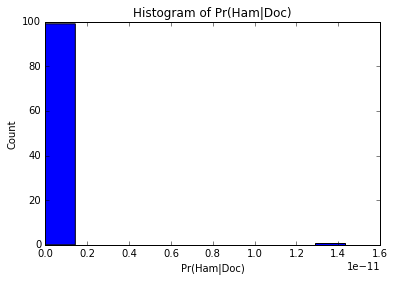

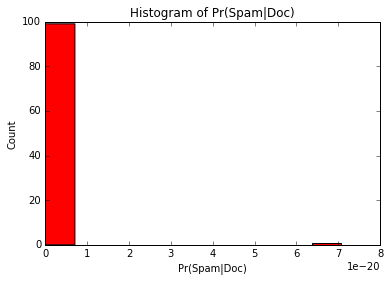

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Plot the histograms
d = np.loadtxt('part-00000', skiprows = 4)

hamData = d[0:100]
spamData = d[100:]

# Plot the Ham data
plt.hist(hamData, color="blue")
plt.xlabel('Pr(Ham|Doc)')
plt.ylabel('Count')
plt.title(r'Histogram of Pr(Ham|Doc)')
plt.show()

# Plot the Spam data
plt.hist(spamData, color="red")
plt.xlabel('Pr(Spam|Doc)')
plt.ylabel('Count')
plt.title(r'Histogram of Pr(Spam|Doc)')
plt.show()


## HW2.4 
Repeat HW2.3 with the following modification: use Laplace plus-one smoothing. Compare the misclassifcation error rates for 2.3 versus 2.4 and explain the differences.

### Reducer (Note: will use the same mapper in HW2.3)

In [6]:
%%writefile reducer.py
#!/usr/bin/python
from __future__ import division # Use Python 3-style division
import sys
from math import log
 
per_word_counts = {} # ham and spam counts about each word
emails = {} # data about each email 
email_counts = [0,0] # number of emails in each class
class_word_counts = [0,0] # number of total (not unique) words in each class

# input comes from STDIN
for line in sys.stdin:
    line = line.strip()
    
    #parse the incoming line
    parts=line.split("\t")
    email=parts[0]
    spam=int(parts[1])
    word=parts[2]
    
    # initialize storage for word/email data
    if word not in per_word_counts.keys():
        per_word_counts[word] = [0,0] # ham count and spam count
        
    if email not in emails.keys():
        emails[email] = {'spam':spam, 'words':[]}
        email_counts[spam] += 1

    # update per-class word count for this word
    per_word_counts[word][spam] += 1
    class_word_counts[spam] += 1

    # update email data 
    emails[email]['words'].append(word)


# train the model

priors = {} # priors for the two classes
condProbs = {} # conditional probabilties for each word
vocab_count = len(per_word_counts) # number of unique words in the total vocabulary

for c in [0,1]:
    priors[c] = email_counts[c] / len(emails)

# Go through each class, and compute the conditional probability of each word in the vocab
for word, counts in per_word_counts.iteritems():
    condProbs[word] = [0,0]
    for c in [0,1]:
        # Calcuate the conditional probability of the word in this class with
        # Laplace plus-one smoothing
        condProbs[word][c] = (counts[c] + 1) / (class_word_counts[c] + vocab_count)

# Now make the predictions

misclassifiedCount = 0
for msgId, email in emails.iteritems():

    # Initialize the score of each class
    scores = [log(priors[0]), log(priors[1])]
        
    # For each word contained in this email, add up its log(condProb)
    # Because we're not using smoothing, we have skip any word where its
    # cond. prob. is zero is either one of the classes.
    for word in email['words']:
        for c in [0,1]:
            scores[c] += log(condProbs[word][c])
    
    # The predicted class is the one which has the higher score
    predicted = 0 if scores[0] > scores[1] else 1
    
    if predicted != email['spam']:
        misclassifiedCount += 1

# Report the result
print "Misclassifcation error rate:", misclassifiedCount / len(emails)


Overwriting reducer.py


### Quick test

In [7]:
!head -n 100 enronemail_1h.txt | python mapper.py | sort | python reducer.py

Misclassifcation error rate: 0.01


### Running in hadoop

In [223]:
!hdfs dfs -rm -r enronemail_1h.txt
!hdfs dfs -put enronemail_1h.txt

16/01/23 23:33:26 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted enronemail_1h.txt
16/01/23 23:33:28 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [232]:
# Hadoop streaming command
!hdfs dfs -rm -r output_hw2.4
!hadoop jar $HADOOP_INSTALL/share/hadoop/tools/lib/hadoop-*streaming*.jar -mapper mapper.py -reducer reducer.py -input enronemail_1h.txt -output output_hw2.4

16/01/24 00:00:22 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted output_hw2.4
16/01/24 00:00:24 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [233]:
# Show the results
!hdfs dfs -cat output_hw2.4/part-00000 

16/01/24 00:00:33 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Misclassifcation error rate: 0.01	


**Compare the misclassifcation error rates for 2.3 versus 2.4 and explain the differences.**

After adding smoothing, the misclassification rate has dropped from 11% to 1%.  It is because in HW2.3, if the conditional probability of a word is zero, the code will ignore that word during prediction.  So it means we have less data, as there were 5386 such cases.  With Laplace plus-one smoothing we have retained those cases and thus the "weight" of those words are used during prediction.

## HW2.5. 
Repeat HW2.4. This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset?

### Reducer (Note: we will reuse the mapper in HW2.4)

In [8]:
%%writefile reducer.py
#!/usr/bin/python
from __future__ import division # Use Python 3-style division
import sys
from math import log
 
per_word_counts = {} # ham and spam counts about each word
emails = {} # data about each email 
email_counts = [0,0] # number of emails in each class
class_word_counts = [0,0] # number of total (not unique) words in each class

# input comes from STDIN
for line in sys.stdin:
    line = line.strip()
    
    #parse the incoming line
    parts=line.split("\t")
    email=parts[0]
    spam=int(parts[1])
    word=parts[2]
    
    # initialize storage for word/email data
    if word not in per_word_counts.keys():
        per_word_counts[word] = [0,0] # ham count and spam count
        
    if email not in emails.keys():
        emails[email] = {'spam':spam, 'words':[]}
        email_counts[spam] += 1

    # update per-class word count for this word
    per_word_counts[word][spam] += 1
    class_word_counts[spam] += 1

    # update email data 
    emails[email]['words'].append(word)


# Remove all words with a frequency of less than three (3) in the training set.
lowFrequencyWords = []
for word, counts in per_word_counts.iteritems():
    if sum(counts) < 3:
        lowFrequencyWords.append(word)

for word in lowFrequencyWords:
    del per_word_counts[word]

    
# train the model

priors = {} # priors for the two classes
condProbs = {} # conditional probabilties for each word
vocab_count = len(per_word_counts) # number of unique words in the total vocabulary

for c in [0,1]:
    priors[c] = email_counts[c] / len(emails)

# Go through each class, and compute the conditional probability of each word in the vocab
for word, counts in per_word_counts.iteritems():
    condProbs[word] = [0,0]
    for c in [0,1]:
        # Calcuate the conditional probability of the word in this class with
        # Laplace plus-one smoothing
        condProbs[word][c] = (counts[c] + 1) / (class_word_counts[c] + vocab_count)


# Now make the predictions

misclassifiedCount = 0
for msgId, email in emails.iteritems():

    # Initialize the score of each class
    scores = [log(priors[0]), log(priors[1])]
        
    # For each word contained in this email, add up its log(condProb)
    # Because we're not using smoothing, we have skip any word where its
    # cond. prob. is zero is either one of the classes.
    for word in email['words']:
        if word not in lowFrequencyWords:
            for c in [0,1]:
                scores[c] += log(condProbs[word][c])
    
    # The predicted class is the one which has the higher score
    predicted = 0 if scores[0] > scores[1] else 1
    
    if predicted != email['spam']:
        misclassifiedCount += 1

# Report the result
print "Misclassifcation error rate:", misclassifiedCount / len(emails)


Overwriting reducer.py


### Quick test

In [9]:
!head -n 100 enronemail_1h.txt | python mapper.py | sort | python reducer.py

Misclassifcation error rate: 0.01


### Running in hadoop

In [243]:
# Hadoop streaming command
!hdfs dfs -rm -r output_hw2.5
!hadoop jar $HADOOP_INSTALL/share/hadoop/tools/lib/hadoop-*streaming*.jar -mapper mapper.py -reducer reducer.py -input enronemail_1h.txt -output output_hw2.5

16/01/24 00:36:34 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted output_hw2.5
16/01/24 00:36:36 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [244]:
# Show the results
!hdfs dfs -cat output_hw2.5/part-00000 

16/01/24 00:36:54 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Misclassifcation error rate: 0.01	


**How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset?**

Now all low frequency words are filtered out and have no impact on the prediction.  In theory that could reduce the misclassification error rate.

## HW2.6 

Benchmark your code with the Python SciKit-Learn implementation of the multinomial Naive Bayes algorithm

It always a good idea to benchmark your solutions against publicly available libraries such as SciKit-Learn, The Machine Learning toolkit available in Python. In this exercise, we benchmark ourselves against the SciKit-Learn implementation of multinomial Naive Bayes.  For more information on this implementation see: http://scikit-learn.org/stable/modules/naive_bayes.html more  

In this exercise, please complete the following:

— Run the Multinomial Naive Bayes algorithm (using default settings) from SciKit-Learn over the same training data used in HW2.5 and report the misclassification error (please note some data preparation might be needed to get the Multinomial Naive Bayes algorithm from SkiKit-Learn to run over this dataset)
- Prepare a table to present your results, where rows correspond to approach used (SkiKit-Learn versus your Hadoop implementation) and the column presents the training misclassification error
— Explain/justify any differences in terms of training error rates over the dataset in HW2.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn 

In [301]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import re
import sys
from sklearn.naive_bayes import MultinomialNB
from IPython.display import display, HTML

emails = pd.read_csv('enronemail_1h.txt', sep='\t', header=None, 
                    names=['id', 'spam', 'subject', 'body'],
                    dtype = {'id':np.object, 'spam':int, 'subject':str, 'body':str})

emails = emails.fillna('') # replace missing value with empty string
emails['text'] = emails.subject + emails.body

# Use CountVectorizer to extract tokens and extract the count of words in each email
# Delimiters are: <spaces> , .
vec = CountVectorizer(token_pattern=r"([^\s.,]+)")

X = vec.fit_transform(emails.text.tolist())
y = np.array(emails.spam.tolist())

# Use MultinomialNB
clf = MultinomialNB()
clf.fit(X, y)

# Get the prediction rate using the same data set
sklearnErrRate = 1 - clf.score(X,y)
print "With sklearn MultinomialNB, error rate =", sklearnErrRate

# Display the two results as table
result = pd.DataFrame(np.array([0.01, sklearnErrRate]), columns=['Error rate'], 
                      index=['Own hadoop code', 'sklearn MultinomialNB'])

display(HTML(result.to_html()))

With sklearn MultinomialNB, error rate = 0.01


,Error rate
Own hadoop code,0.01
sklearn MultinomialNB,0.01


**Explain/justify any differences in terms of training error rates over the dataset in HW2.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn.** 

I could not see any difference.

### stop yarn and hdfs

In [10]:
!/usr/local/Cellar/hadoop/2.7.1/sbin/stop-yarn.sh
!/usr/local/Cellar/hadoop/2.7.1/sbin/stop-dfs.sh

stopping yarn daemons
stopping resourcemanager
localhost: stopping nodemanager
localhost: nodemanager did not stop gracefully after 5 seconds: killing with kill -9
no proxyserver to stop
16/01/26 18:31:29 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Stopping namenodes on [localhost]
localhost: stopping namenode
localhost: stopping datanode
Stopping secondary namenodes [0.0.0.0]
0.0.0.0: stopping secondarynamenode
16/01/26 18:31:48 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
